# Unsupervised Object Detection

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/1-getting-started/DTGS151_unsupervised_object_detection_with_lodestar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
# !pip install deeplay deeptrack  # Uncomment if running on Colab/Kaggle.

This tutorial demonstrates how to use a self-supervised approach (LodeSTAR) to detect particles in microscopy images.

> This tutorial is based on the article:
>
>   __Single-shot self-supervised object detection in microscopy.__
>   Benjamin Midtvedt, Jesús Pineda, Fredrik Skärberg, Erik Olsén, Harshith Bachimanchi, Emelie Wesén, Elin K. Esbjörner, Erik Selander, Fredrik Höök, Daniel Midtvedt & Giovanni Volpe.
>   _Nature Communications_, volume 13, article number 7492 (2022).
>
> <a href="https://doi.org/10.1063/5.0034891" alt="LodeSTAR article"><img src="https://img.shields.io/badge/article-10.1063/5.0034891-blue"></a> 

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

## 1. Downloading the Dataset

You will use the BF-C2DL-HSC dataset from the Cell Tracking Challenge.
This is a series of videos of proliferating mouse hematopoietic stem cells. 
Importantly, you can use the annotations provided for the challenge to evaluate the detection performance.
This dataset is available at http://data.celltrackingchallenge.net/training-datasets/BF-C2DL-HSC.zip.

In [3]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "cell_detection_dataset")
if not os.path.exists(dataset_path):
    url = ("http://data.celltrackingchallenge.net/training-datasets/"
           "BF-C2DL-HSC.zip")
    download_url(url, ".")
    _extract_zip("BF-C2DL-HSC.zip", dataset_path, None)
    os.remove("BF-C2DL-HSC.zip")

dir = os.path.join(dataset_path, "BF-C2DL-HSC")

You will use `Source` to dynamically load the files and create a pipeline including both the images and the relative labels of the cell positions.

In [4]:
import glob
from skimage.measure import regionprops

sources = dt.sources.Source(
    image_path=sorted(glob.glob(os.path.join(dir, "02", "*.tif"))),
    label_path=sorted(glob.glob(os.path.join(dir, "02_GT", "TRA", "*.tif"))),
)

image = dt.LoadImage(sources.image_path)[:, :300] / 256
label = dt.LoadImage(sources.label_path)[:, :300] >> regionprops

pipeline = image & label

You can now plot some images together with the ground truth values of the cell positions.

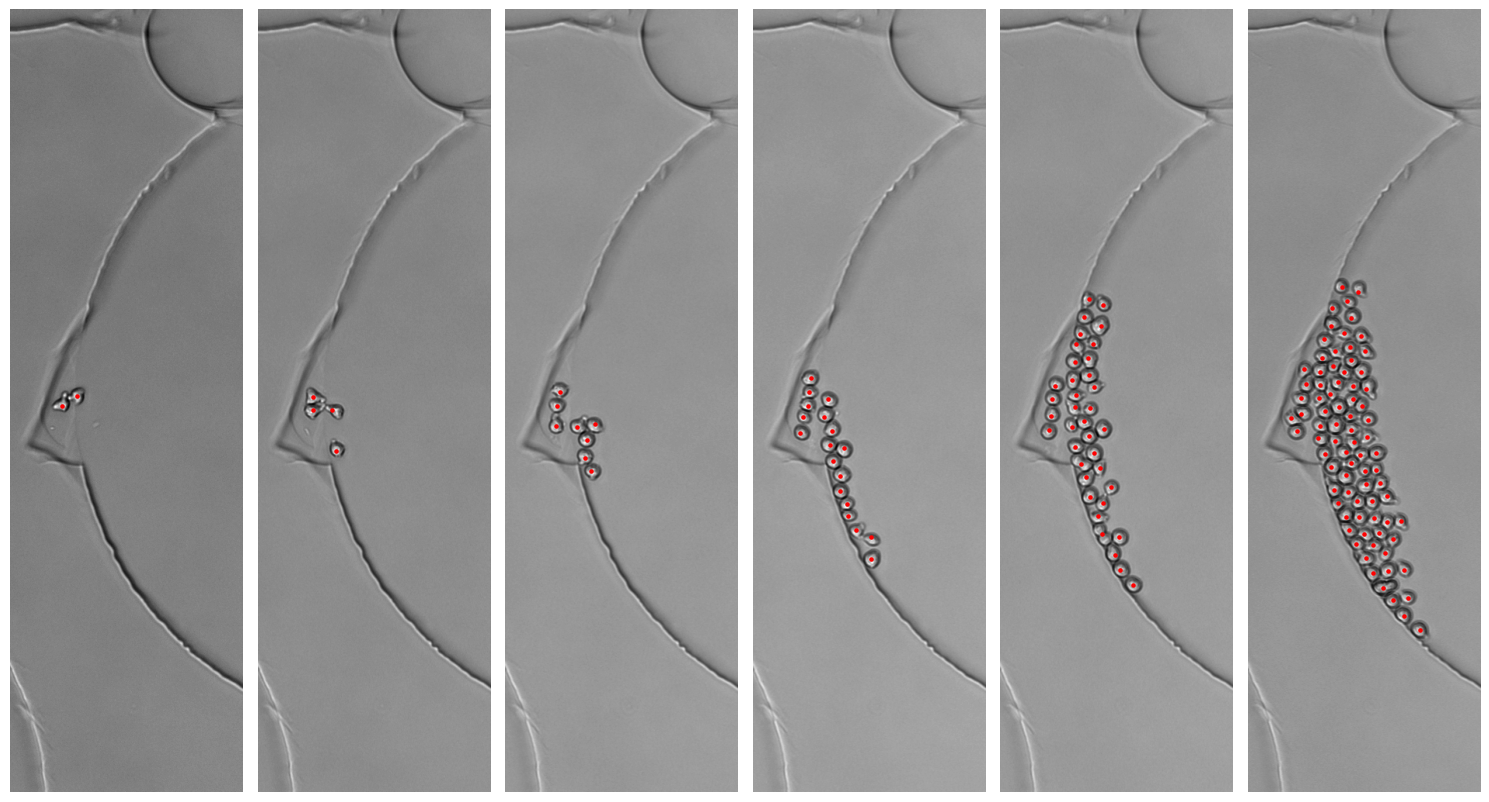

In [5]:
import skimage.io

plt.figure(figsize=(15, 10))

for plt_index, data_index in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[data_index])
    
    plt.subplot(1, 6, plt_index + 1)
    plt.imshow(image, cmap="gray")
    for prop in props:
        plt.scatter(prop.centroid[1], prop.centroid[0], s=5, color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2. Preparing the Training Crop

You will use a single crop of a single cell to train the neural network.

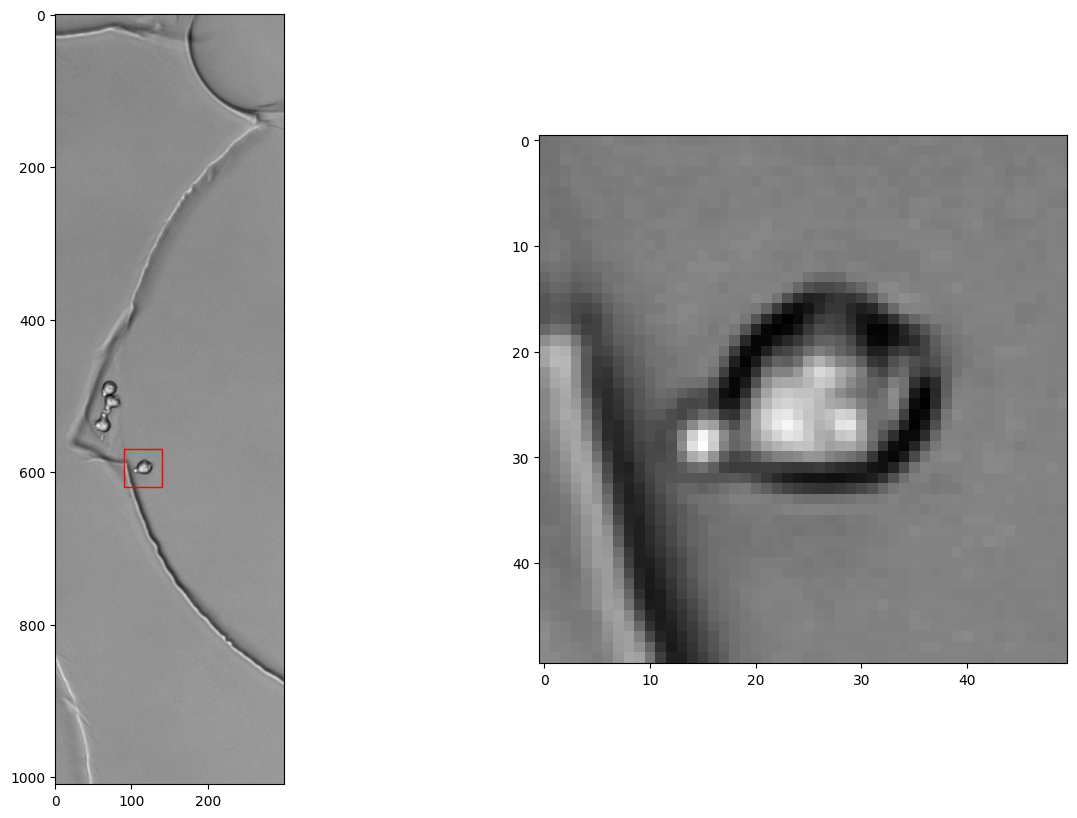

In [6]:
import matplotlib.patches as patches

crop_frame_index = 282
crop_size = 50
crop_x0, crop_y0 = 595 - crop_size // 2, 115 - crop_size // 2

image, *props = pipeline(sources[crop_frame_index])
crop = image[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size]

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

plt.subplot(1, 2, 2)
plt.imshow(crop, cmap="gray")

plt.show()

## 3. Training the Neural Network

You will use this crop to create a training pipeline.

In [7]:
import torch

training_pipeline = (
    dt.Value(crop)
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, 
                                      replace=False)

In [8]:
import deeptrack.deeplay as dl 

dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

In [9]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=200)
trainer.fit(lodestar, dataloader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The t

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │ train │
│ 1 │ between_loss  │ L1Loss                     │      0 │ train │
│ 2 │ within_loss   │ L1Loss                     │      0 │ train │
│ 3 │ train_metrics │ MetricCollection           │      0 │ train │
│ 4 │ val_metrics   │ MetricCollection           │      0 │ train │
│ 5 │ test_metrics  │ MetricCollection           │      0 │ train │
│ 6 │ optimizer     │ Adam                       │      0 │ train │
└───┴───────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 39                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


You can now plot its predictions.

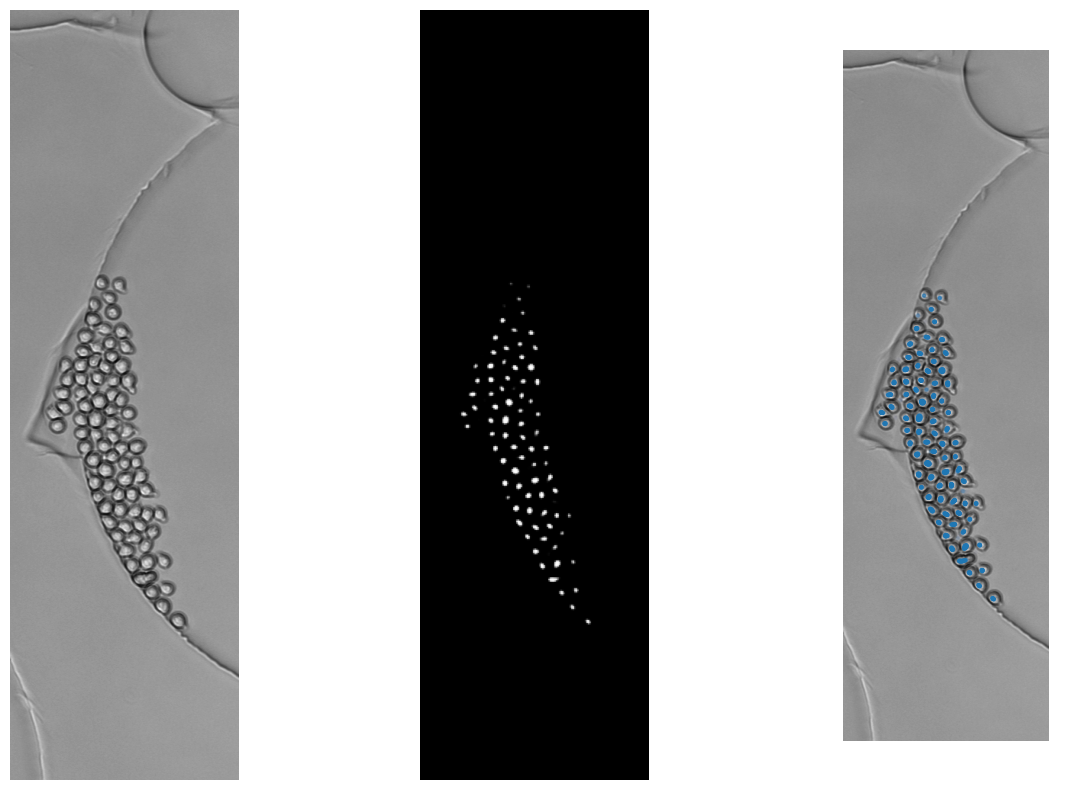

In [10]:
image_index = 1500
image, *props = pipeline(sources[image_index])
torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image, cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

The image is shown on the left.
The middle image shows the probability channel $\rho_i$, where bright spots near the centers of the cells show that the neural network correctly thinks there is a high probability that there is a cell in those positions.
The right image shows the predicted positions, which correctly cluster near the cells, demonstrating the network's accuracy in replicating the cell positions from the input image, which is the primary goal of this task.

## 4. Evaluating the Performance of the Trained Network

Fix the parameters of the postprocessing:
$\alpha$ should be high if the objects are very different and $\beta$ should be high if the objects are very similar ($\alpha + \beta = 1$).
The `cutoff` parameter determines the threshold: higher values mean fewer objects are detected and lower values mean more objects are detected.
The `mode` parameter determines how the threshold is calculated. As a rule of thumb, use `mode="constant"` if the number of objects changes significantly between images, and use `mode="quantile"` if the number of objects is roughly constant between images.

In [11]:
alpha = 0.2
beta = 0.8
cutoff = 0.2
mode = "constant"

You can now plot the positions of the detected cells.

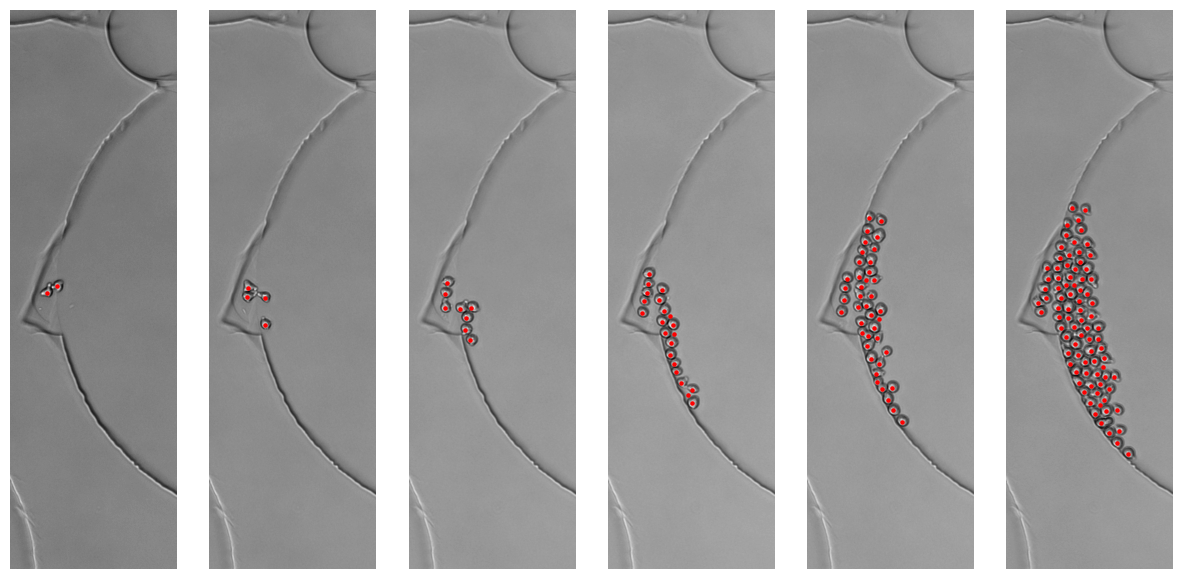

In [12]:
plt.figure(figsize=(15, 10))

for plot_idx, frame_idx in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[frame_idx])
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)[0]

    plt.subplot(1, 6, plot_idx + 1)
    plt.imshow(image, cmap="gray")
    plt.scatter(detections[:, 1], detections[:, 0], s=5, color="red")
    plt.axis("off")

plt.show()

Calculate the F1-score to quantify the neural network performance.

In [13]:
import scipy
import tqdm 

distance_th = 10

TP, FP, FN = 0, 0, 0
for source in tqdm.tqdm(sources[::10]):
    image, *props = pipeline(source)
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                 mode="constant", cutoff=cutoff)[0]
    centroids = np.array([prop.centroid[:2] for prop in props])

    distance_matrix = scipy.spatial.distance_matrix(detections, centroids)
    row_idx, col_idx = scipy.optimize.linear_sum_assignment(distance_matrix)

    filtered_row_ind = row_idx[distance_matrix[row_idx, col_idx] < distance_th]
    filtered_col_ind = col_idx[distance_matrix[row_idx, col_idx] < distance_th]

    TP += len(filtered_row_ind)
    FP += len(detections) - len(filtered_row_ind)
    FN += len(centroids) - len(filtered_col_ind)

F1 = 2 * TP / (2 * TP + FP + FN)

print(f"""
TP: {TP}
FP: {FP}
FN: {FN}
F1: {F1}  
""")

100%|██████████| 177/177 [00:39<00:00,  4.45it/s]


TP: 6456
FP: 359
FN: 19
F1: 0.9715575620767495  

